# Load the Dataset

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)
print((df.count(), len(df.columns)))


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/03 20:11:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/10/03 20:12:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

(72498, 131)


# Feature Engineering

In [2]:
#|eval: true
#|echo: false
#| fig-align: center


from pyspark.sql.functions import col, pow, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, BooleanType, StringType



# Drop rows with NA values in relevant columns
df_feature_eng = df.dropna(subset=["SALARY", "MIN_YEARS_EXPERIENCE", "STATE_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "MIN_EDULEVELS_NAME", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"])




eda_cols = ["SALARY", "MIN_YEARS_EXPERIENCE", "DURATION", "COMPANY_IS_STAFFING", "IS_INTERNSHIP", "STATE_NAME", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME", "MIN_EDULEVELS_NAME"]


df_feature_eng = df_feature_eng.select(eda_cols)


#Clean categorical variable REMOTE_TYPE_NAME
df_feature_eng = df_feature_eng.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)



#Clean categorical variable EMPLOYMENT_TYPE_NAME
df_feature_eng = df_feature_eng.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)


# Categorical columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME"]

# continuous columns
continuous_cols = ["MIN_YEARS_EXPERIENCE", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"]

# Setup pipeline stages for indexing and encoding categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Idx", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_Idx", outputCol=f"{col}_vec") for col in categorical_cols]


In [3]:
assembler = VectorAssembler(
inputCols=["MIN_YEARS_EXPERIENCE", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"] + [f"{col}_vec" for col in categorical_cols], outputCol="features"
)


# Build Pipeline and Transform
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df_feature_eng).transform(df_feature_eng)


# Create squared term for Polynomial Regression
data = data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

# Assemble Polynomial Features
assembler_poly = VectorAssembler(
inputCols=[ "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"] + [f"{col}_vec" for col in categorical_cols], outputCol="features_poly"
)
data = assembler_poly.transform(data)


# Split Data
regression_train, regression_test = data.randomSplit([0.8, 0.2], seed=42)


# Show final structure
data.select("SALARY", "features", "features_poly").show(5, truncate=False)

+------+--------------------------------------+-------------------------------------------+
|SALARY|features                              |features_poly                              |
+------+--------------------------------------+-------------------------------------------+
|192800|(9,[0,1,4,6],[6.0,55.0,1.0,1.0])      |(10,[0,1,2,5,7],[6.0,36.0,55.0,1.0,1.0])   |
|125900|(9,[0,1,4,6],[12.0,18.0,1.0,1.0])     |(10,[0,1,2,5,7],[12.0,144.0,18.0,1.0,1.0]) |
|118560|[5.0,20.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0]|[5.0,25.0,20.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0]|
|192800|(9,[0,1,4,6],[6.0,55.0,1.0,1.0])      |(10,[0,1,2,5,7],[6.0,36.0,55.0,1.0,1.0])   |
|116500|(9,[0,1,4,6],[12.0,16.0,1.0,1.0])     |(10,[0,1,2,5,7],[12.0,144.0,16.0,1.0,1.0]) |
+------+--------------------------------------+-------------------------------------------+
only showing top 5 rows


# Linear Regression

In [4]:
from pyspark.ml.regression import LinearRegression

# Creating Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

# training the model
lr_model = lr.fit(regression_train)

25/10/03 20:12:28 WARN Instrumentation: [30829445] regParam is zero, which might cause numerical instability and overfitting.


In [5]:
# Making predictions
predictions = lr_model.transform(regression_test)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")    

# Print coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


R²: 0.27747505372039105
RMSE: 35354.21968106297
MAE: 27394.263039528487
Coefficients: [6831.19516740728,-16.944672967567364,-8335.0742639915,455.51244715909286,-1261.5274637185041,-3264.749623577828,7407.370489759505,8150.657530209268,22412.845022831403]
Intercept: 76301.15556556016


In [6]:
import pandas as pd
from scipy.stats import t

summary = lr_model.summary
coefficients = lr_model.coefficients
intercept = lr_model.intercept
std_errors = summary.coefficientStandardErrors
t_values = summary.tValues
p_values = summary.pValues

# Calculate degrees of freedom
n = summary.numInstances
p = len(coefficients)
dof = n - p - 1

# Critical t-value for 95% confidence interval (two-tailed)
critical_value = t.ppf(0.975, dof)



# Create DataFrame
coef_df = pd.DataFrame({
    "Feature": ["Intercept"] + [f"Feature_{i}" for i in range(p)],
    "Coefficient": [intercept] + coefficients.tolist(),
    "Std Error": std_errors,
    "t-value": t_values,
    "p-value": p_values
})

# Calculate confidence intervals
coef_df["95% CI Lower"] = coef_df["Coefficient"] - critical_value * coef_df["Std Error"]
coef_df["95% CI Upper"] = coef_df["Coefficient"] + critical_value * coef_df["Std Error"]

print(coef_df)




     Feature   Coefficient    Std Error    t-value       p-value  \
0  Intercept  76301.155566   102.177226  66.856338  0.000000e+00   
1  Feature_0   6831.195167    23.498093  -0.721108  4.708573e-01   
2  Feature_1    -16.944673  6746.455365  -1.235475  2.166790e-01   
3  Feature_2  -8335.074264  1058.463112   0.430353  6.669471e-01   
4  Feature_3    455.512447  2985.376196  -0.422569  6.726176e-01   
5  Feature_4  -1261.527464  3602.352700  -0.906283  3.648051e-01   
6  Feature_5  -3264.749624  2427.654733   3.051245  2.284094e-03   
7  Feature_6   7407.370490  2493.856758   3.268294  1.085129e-03   
8  Feature_7   8150.657530  3132.647036   7.154603  8.897327e-13   
9  Feature_8  22412.845023  3524.083191  21.651349  0.000000e+00   

   95% CI Lower  95% CI Upper  
0  76100.870974  76501.440157  
1   6785.134943   6877.255392  
2 -13241.134758  13207.245412  
3 -10409.840439  -6260.308089  
4  -5396.328284   6307.353179  
5  -8322.746176   5799.691249  
6  -8023.362245   1493.8629

In [7]:
feature_names = [
    "MIN_YEARS_EXPERIENCE",
    "DURATION",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    # Add your categorical feature dummy variable names here, e.g.:
    "EMPLOYMENT_TYPE_NAME_A",
    "EMPLOYMENT_TYPE_NAME_B",
    "REMOTE_TYPE_NAME_X",
    "REMOTE_TYPE_NAME_Y",
    "REMOTE_TYPE_NAME_Z"
]

coef_df = pd.DataFrame({
    "Feature": ["Intercept"] + feature_names,
    "Coefficient": [intercept] + coefficients.tolist(),
    "Std Error": std_errors,
    "t-value": t_values,
    "p-value": p_values
})

# Calculate confidence intervals
coef_df["95% CI Lower"] = coef_df["Coefficient"] - critical_value * coef_df["Std Error"]
coef_df["95% CI Upper"] = coef_df["Coefficient"] + critical_value * coef_df["Std Error"]

print(coef_df)

                  Feature   Coefficient    Std Error    t-value       p-value  \
0               Intercept  76301.155566   102.177226  66.856338  0.000000e+00   
1    MIN_YEARS_EXPERIENCE   6831.195167    23.498093  -0.721108  4.708573e-01   
2                DURATION    -16.944673  6746.455365  -1.235475  2.166790e-01   
3           IS_INTERNSHIP  -8335.074264  1058.463112   0.430353  6.669471e-01   
4     COMPANY_IS_STAFFING    455.512447  2985.376196  -0.422569  6.726176e-01   
5  EMPLOYMENT_TYPE_NAME_A  -1261.527464  3602.352700  -0.906283  3.648051e-01   
6  EMPLOYMENT_TYPE_NAME_B  -3264.749624  2427.654733   3.051245  2.284094e-03   
7      REMOTE_TYPE_NAME_X   7407.370490  2493.856758   3.268294  1.085129e-03   
8      REMOTE_TYPE_NAME_Y   8150.657530  3132.647036   7.154603  8.897327e-13   
9      REMOTE_TYPE_NAME_Z  22412.845023  3524.083191  21.651349  0.000000e+00   

   95% CI Lower  95% CI Upper  
0  76100.870974  76501.440157  
1   6785.134943   6877.255392  
2 -13241.134

# Polynomial Regression

In [8]:
from pyspark.ml.regression import LinearRegression

# Creating Polynomial Regression Model
lr_poly = LinearRegression(featuresCol="features_poly", labelCol="SALARY")


#training the model
lr_poly_model = lr_poly.fit(regression_train)



25/10/03 20:13:02 WARN Instrumentation: [6748e543] regParam is zero, which might cause numerical instability and overfitting.


In [9]:
# Making Predictions
predictions_poly = lr_poly_model.transform(regression_test)

# Evaluate the Polynomial model
evaluator_r2_poly = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse_poly = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae_poly = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2_poly = evaluator_r2_poly.evaluate(predictions_poly)
rmse_poly = evaluator_rmse_poly.evaluate(predictions_poly)
mae_poly = evaluator_mae_poly.evaluate(predictions_poly)

print(f"R²: {r2_poly}")
print(f"RMSE: {rmse_poly}")
print(f"MAE: {mae_poly}")

# Print coefficients and intercept for Polynomial Regression
print("Coefficients:", lr_poly_model.coefficients)
print("Intercept:", lr_poly_model.intercept)





R²: 0.2999111042236341
RMSE: 34800.97629236496
MAE: 26815.734743406734
Coefficients: [12321.424633194574,-410.81806941944365,-16.033371304985252,-4816.276067454366,-122.15434444725373,-4962.654169742263,-6422.5061156546435,6702.637628410731,7601.6311647419425,20955.03322404107]
Intercept: 67481.20783767497


In [10]:
import pandas as pd
from scipy.stats import t

summary_poly = lr_poly_model.summary
coefficients_poly = lr_poly_model.coefficients
intercept_poly = lr_poly_model.intercept
std_errors_poly = summary_poly.coefficientStandardErrors
t_values_poly = summary_poly.tValues
p_values_poly = summary_poly.pValues

# Calculate degrees of freedom
n_poly = summary_poly.numInstances
p_poly = len(coefficients_poly)
dof_poly = n_poly - p_poly - 1

# Critical t-value for 95% confidence interval (two-tailed)
critical_value_poly = t.ppf(0.975, dof_poly)



# Create DataFrame
coef_poly_df = pd.DataFrame({
    "Feature": ["Intercept"] + [f"Feature_{i}" for i in range(p_poly)],
    "Coefficient": [intercept_poly] + coefficients_poly.tolist(),
    "Std Error": std_errors_poly,
    "t-value": t_values_poly,
    "p-value": p_values_poly
})

# Calculate confidence intervals
coef_poly_df["95% CI Lower"] = coef_poly_df["Coefficient"] - critical_value_poly * coef_poly_df["Std Error"]
coef_poly_df["95% CI Upper"] = coef_poly_df["Coefficient"] + critical_value_poly * coef_poly_df["Std Error"]    

print(coef_poly_df)





      Feature   Coefficient    Std Error    t-value       p-value  \
0   Intercept  67481.207838   363.827753  33.866093  0.000000e+00   
1   Feature_0  12321.424633    26.151749 -15.709009  0.000000e+00   
2   Feature_1   -410.818069    23.252997  -0.689518  4.905108e-01   
3   Feature_2    -16.033371  6679.822656  -0.721019  4.709126e-01   
4   Feature_3  -4816.276067  1048.064896  -0.116552  9.072169e-01   
5   Feature_4   -122.154344  2963.608208  -1.674531  9.405324e-02   
6   Feature_5  -4962.654170  3570.430449  -1.798804  7.207562e-02   
7   Feature_6  -6422.506116  2402.744508   2.789576  5.286330e-03   
8   Feature_7   6702.637628  2468.084436   3.079972  2.075044e-03   
9   Feature_8   7601.631165  3101.351134   6.756743  1.478861e-11   
10  Feature_9  20955.033224  3532.222708  19.104460  0.000000e+00   

    95% CI Lower  95% CI Upper  
0   66768.044088  68194.371588  
1   12270.162795  12372.686472  
2    -456.397864   -365.238275  
3  -13109.612230  13077.545488  
4   -6

In [ ]:
feature_names_poly = [
    "MIN_YEARS_EXPERIENCE",
    "MIN_YEARS_EXPERIENCE_SQ",
    "DURATION",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    # For categorical column EMPLOYMENT_TYPE_NAME_vec, list categories manually
    "EMPLOYMENT_TYPE_NAME_A",  # replace _A with actual category name
    "EMPLOYMENT_TYPE_NAME_B",
    # For categorical column REMOTE_TYPE_NAME_vec, list categories manually
    "REMOTE_TYPE_NAME_X",
    "REMOTE_TYPE_NAME_Y",
    "REMOTE_TYPE_NAME_Z"
]

# Then build your DataFrame as before:
coef_poly_df = pd.DataFrame({
    "Feature": ["Intercept"] + feature_names_poly,
    "Coefficient": [intercept_poly] + coefficients_poly.tolist(),
    "Std Error": std_errors_poly,
    "t-value": t_values_poly,
    "p-value": p_values_poly
})

# Calculate confidence intervals
coef_poly_df["95% CI Lower"] = coef_poly_df["Coefficient"] - critical_value_poly * coef_poly_df["Std Error"]
coef_poly_df["95% CI Upper"] = coef_poly_df["Coefficient"] + critical_value_poly * coef_poly_df["Std Error"]

print(coef_poly_df)

                    Feature   Coefficient    Std Error    t-value  \
0                 Intercept  67481.207838   363.827753  33.866093   
1      MIN_YEARS_EXPERIENCE  12321.424633    26.151749 -15.709009   
2   MIN_YEARS_EXPERIENCE_SQ   -410.818069    23.252997  -0.689518   
3                  DURATION    -16.033371  6679.822656  -0.721019   
4             IS_INTERNSHIP  -4816.276067  1048.064896  -0.116552   
5       COMPANY_IS_STAFFING   -122.154344  2963.608208  -1.674531   
6    EMPLOYMENT_TYPE_NAME_A  -4962.654170  3570.430449  -1.798804   
7    EMPLOYMENT_TYPE_NAME_B  -6422.506116  2402.744508   2.789576   
8        REMOTE_TYPE_NAME_X   6702.637628  2468.084436   3.079972   
9        REMOTE_TYPE_NAME_Y   7601.631165  3101.351134   6.756743   
10       REMOTE_TYPE_NAME_Z  20955.033224  3532.222708  19.104460   

         p-value  95% CI Lower  95% CI Upper  
0   0.000000e+00  66768.044088  68194.371588  
1   0.000000e+00  12270.162795  12372.686472  
2   4.905108e-01   -456.397864

# Random Forest Regressor

In [12]:
from pyspark.ml.regression import RandomForestRegressor

# choose hyperparameters 
num_trees = 400
max_depth = 8


# Initialize Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="SALARY", numTrees =num_trees, maxDepth=max_depth, seed=42)

# Fit the model
rf_model = rf.fit(regression_train)

# Optionally evaluate on test data
predictions_rf = rf_model.transform(regression_test)
predictions_rf.select("SALARY", "prediction").show(5)

print("Feature Importances:", rf_model.featureImportances
)


25/10/03 20:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
25/10/03 20:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1990.5 KiB
25/10/03 20:14:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
25/10/03 20:14:12 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
25/10/03 20:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1306.4 KiB
25/10/03 20:14:20 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
25/10/03 20:14:26 WARN DAGScheduler: Broadcasting large task binary with size 1733.0 KiB


+------+------------------+
|SALARY|        prediction|
+------+------------------+
| 22880| 74106.38192336867|
| 27040|113606.84821455473|
| 29250| 74860.70361212626|
| 31200| 95749.51638268944|
| 31200|112217.22076522365|
+------+------------------+
only showing top 5 rows
Feature Importances: (9,[0,1,2,3,4,5,6,7,8],[0.8501759574296253,0.08032999920757751,0.0017161541381864127,0.00854926094422917,0.009713977164382326,0.007732422107921255,0.012865228041169805,0.010307604399175071,0.01860939656773313])


/tmp/ipykernel_7396/2169804401.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




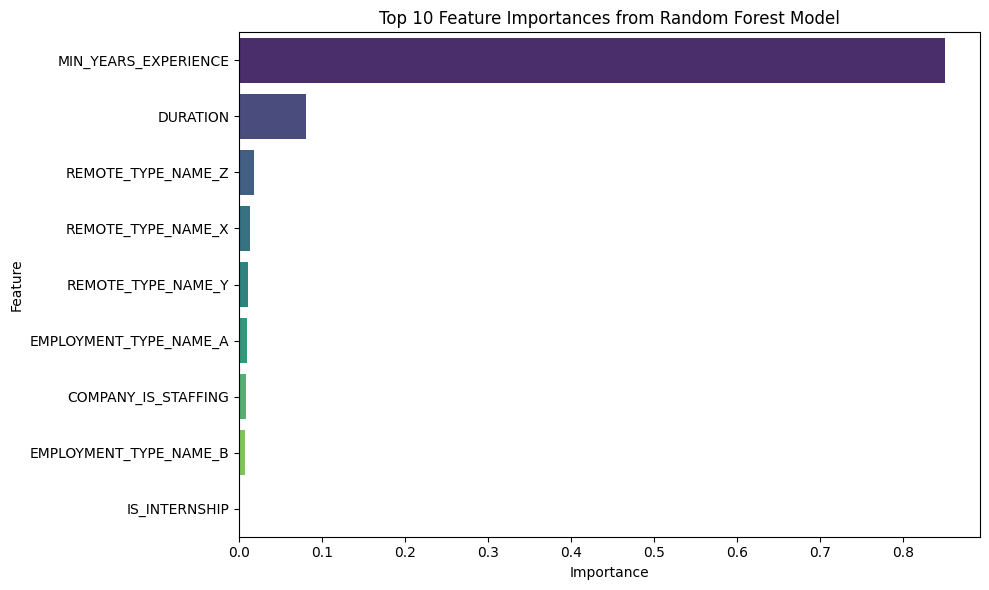

In [25]:
# Feature Importance Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importances = rf_model.featureImportances.toArray()

feat_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

feat_imp_df = feat_importance_df.sort_values(by="Importance", ascending=False).head(10)

# Making the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Top 10 Feature Importances from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('output/rf_feature_importance.png')
plt.show()










# Compare 3 Models – GLR, Polynomial, RF

In [28]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique row ID to original data
data_indexed = data.withColumn("row_id", monotonically_increasing_id())

# Generate predictions from each model, keeping row_id and relevant columns
predictions_lr = lr_model.transform(data_indexed) \
    .withColumnRenamed("prediction", "LR_Prediction") \
    .select("row_id", "SALARY", "LR_Prediction")

predictions_poly = lr_poly_model.transform(data_indexed) \
    .withColumnRenamed("prediction", "Poly_Prediction") \
    .select("row_id", "Poly_Prediction")

predictions_rf = rf_model.transform(data_indexed) \
    .withColumnRenamed("prediction", "RF_Prediction") \
    .select("row_id", "RF_Prediction")

# Join all predictions on row_id
combined_predictions = predictions_lr \
    .join(predictions_poly, on="row_id") \
    .join(predictions_rf, on="row_id") \
    .select("SALARY", "LR_Prediction", "Poly_Prediction", "RF_Prediction")

combined_predictions.show(5)





+------+------------------+------------------+------------------+
|SALARY|     LR_Prediction|   Poly_Prediction|     RF_Prediction|
+------+------------------+------------------+------------------+
|192800|122502.21258282862|127478.45317463673| 150419.0700588687|
|125900| 164116.3364870723|157631.88421478868|142783.37872342562|
|118560|117462.88045689506|121014.03449261448|122520.02802832137|
|192800|122502.21258282862|127478.45317463673| 150419.0700588687|
|116500|164150.22583300743| 157663.9509573987|142117.03903479254|
+------+------------------+------------------+------------------+
only showing top 5 rows


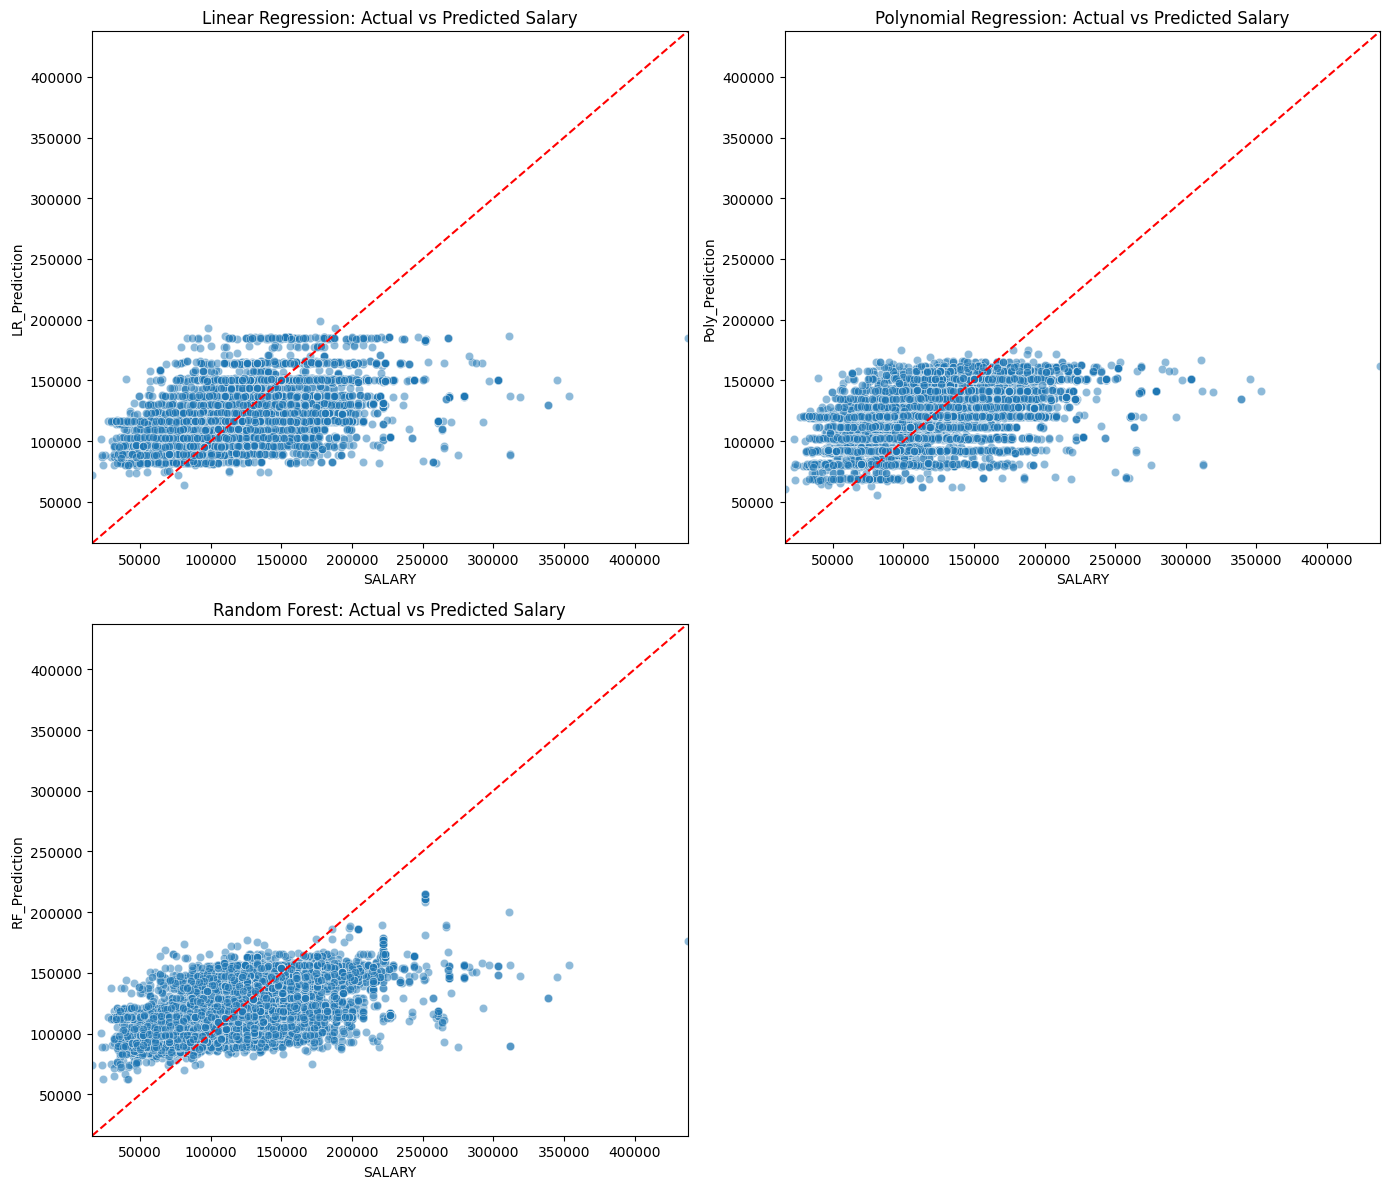

In [50]:
# A 2x2 grid plot comparing the actual vs. predicted values for each model.
# Use seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Pandas
preds_pd = combined_predictions.toPandas()

# Common Axis Limits 
min_val = preds_pd["SALARY"].min()
max_val = preds_pd["SALARY"].max()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

#plot linear regression
sns.scatterplot(ax=axes[0, 0], x="SALARY", y="LR_Prediction", data=preds_pd, alpha=0.5)
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[0, 0].set_title("Linear Regression: Actual vs Predicted Salary")
axes[0, 0].set_xlim(min_val, max_val)
axes[0, 0].set_ylim(min_val, max_val)

#plot polynomial regression
sns.scatterplot(ax=axes[0, 1], x="SALARY", y="Poly_Prediction", data=preds_pd, alpha=0.5)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[0, 1].set_title("Polynomial Regression: Actual vs Predicted Salary")
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)   

#plot random forest
sns.scatterplot(ax=axes[1, 0], x="SALARY", y="RF_Prediction", data=preds_pd, alpha=0.5)
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[1, 0].set_title("Random Forest: Actual vs Predicted Salary")
axes[1, 0].set_xlim(min_val, max_val)
axes[1, 0].set_ylim(min_val, max_val)       

#Hide unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('output/model_Predictions_V_Actuals_For_Each_Model.png')
plt.show()








In [29]:
# Calculating RMSE for each model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="SALARY", metricName="rmse")
rmse_lr = evaluator.evaluate(combined_predictions.withColumnRenamed("LR_Prediction", "prediction"))
rmse_poly = evaluator.evaluate(combined_predictions.withColumnRenamed("Poly_Prediction", "prediction"))
rmse_rf = evaluator.evaluate(combined_predictions.withColumnRenamed("RF_Prediction", "prediction"))
print(f"RMSE - Linear Regression: {rmse_lr}")
print(f"RMSE - Polynomial Regression: {rmse_poly}")
print(f"RMSE - Random Forest: {rmse_rf}")   


RMSE - Linear Regression: 36023.3148101222
RMSE - Polynomial Regression: 35610.993411374555
RMSE - Random Forest: 33516.18792099613


In [35]:
# AIC for each model 

# linear regression model AIC calculation easy way

import math
n = regression_test.count()
p = len(lr_model.coefficients)
rss_lr = lr_model.summary.meanSquaredError * n
aic_lr = n * math.log(rss_lr / n) + 2 * p
print(f"AIC - Linear Regression: {aic_lr}")

# polynomial regression model AIC calculation easy way
n_poly = regression_test.count()
p_poly = len(lr_poly_model.coefficients)
rss_poly = lr_poly_model.summary.meanSquaredError * n_poly
aic_poly = n_poly * math.log(rss_poly / n_poly) + 2 * p_poly
print(f"AIC - Polynomial Regression: {aic_poly}")   










AIC - Linear Regression: 20359.947815706055


AIC - Polynomial Regression: 20341.537781502302


In [30]:
# Calculating Log likelihood Pyspark Models
import math

# Log Likelihood for Linear Regression
n = combined_predictions.count()
rss_lr = combined_predictions.withColumn("squared_error", (col("SALARY") - col("LR_Prediction"))**2).groupBy().sum("squared_error").collect()[0][0]
ll_lr = -n/2 * (math.log(2 * math.pi) + 1 - math.log(n) + math.log(rss_lr)) 

# Log Likelihood for Polynomial Regression
rss_poly = combined_predictions.withColumn("squared_error", (col("SALARY") - col("Poly_Prediction"))**2).groupBy().sum("squared_error").collect()[0][0]
ll_poly = -n/2 * (math.log(2 * math.pi) + 1 - math.log(n) + math.log(rss_poly))

# Log Likelihood for Random Forest
rss_rf = combined_predictions.withColumn("squared_error", (col("SALARY") - col("RF_Prediction"))**2).groupBy().sum("squared_error").collect()[0][0]
ll_rf = -n/2 * (math.log(2 * math.pi) + 1 - math.log(n) + math.log(rss_rf)) 

print(f"Log Likelihood - Linear Regression: {ll_lr}")
print(f"Log Likelihood - Polynomial Regression: {ll_poly}")
print(f"Log Likelihood - Random Forest: {ll_rf}")       


Log Likelihood - Linear Regression: -171706.96027751334
Log Likelihood - Polynomial Regression: -171541.0037386337
Log Likelihood - Random Forest: -170667.02148159023


In [31]:
# Calculating BIC for each model

#BIC for Linear Regression
k_lr = len(lr_model.coefficients) + 1  # number of parameters (coefficients + intercept)
bic_lr = -2 * ll_lr + k_lr * math.log(n)

#BIC for Polynomial Regression
k_poly = len(lr_poly_model.coefficients) + 1            
bic_poly = -2 * ll_poly + k_poly * math.log(n)

#BIC for Random Forest
k_rf = num_trees * max_depth  # approximate number of parameters
bic_rf = -2 * ll_rf + k_rf * math.log(n)        

print(f"BIC - Linear Regression: {bic_lr}")
print(f"BIC - Polynomial Regression: {bic_poly}")
print(f"BIC - Random Forest: {bic_rf}") 

BIC - Linear Regression: 343509.68149482517
BIC - Polynomial Regression: 343187.3445110457
BIC - Random Forest: 371977.54369869444


# Missing Value Treatment

1. Replace the missing values in Salary by Median of Salary based on the EMPLOYMENT_TYPE or EMPLOYMENT_TYPE_NAME. If both are missing, then use the overall median of Salary to replace it.



In [14]:
# Missing Value Treatment
from pyspark.sql.functions import col, when, isnan, count

# 1. Replace the missing values in Salary by Median of Salary based on the EMPLOYMENT_TYPE or EMPLOYMENT_TYPE_NAME. If both are missing, then use the overall median of Salary to replace it.

from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, expr, median
from pyspark.sql import functions as F

# Calculate overall median salary
overall_median_salarly = df.approxQuantile("SALARY", [0.5], 0.01)[0]

median_by_employment_type = df.groupBy("EMPLOYMENT_TYPE").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))
median_by_employment_type_name = df.groupBy("EMPLOYMENT_TYPE_NAME").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join median values back to the original dataframe
df_salary_imputed = df.join(median_by_employment_type, on="EMPLOYMENT_TYPE", how = "left").join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how = "left")


# Replace missing SALARY values
df_salary_imputed=df_salary_imputed.withColumn("SALARY", when(col("SALARY").isNull(), 
                                when (col("median_salary_emp_type").isNotNull(), col("median_salary_emp_type"))
                                .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
                                .otherwise(overall_median_salarly)
).otherwise(col("SALARY"))) 


df_salary_imputed.show(5)

+--------------------+---------------+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+--------------------+--------------------+-------------+--------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+----

In [15]:
#|eval: true
#|echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, BooleanType, StringType

# Drop Rows from Relevant Columns
regression_df = df_salary_imputed.dropna(subset=["SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING",  "median_salary_emp_type", "median_salary_emp_type_name"
    ]).select("SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING", "median_salary_emp_type", "median_salary_emp_type_name")

# Categorical Columns
categorical_cols = ["EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"  
    
    
]

regression_df = regression_df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))
regression_df = regression_df.withColumn("COMPANY_IS_STAFFING", col("COMPANY_IS_STAFFING").cast(IntegerType()))
regression_df.show(5, truncate=False)



+--------+--------------------+--------------------+-----------------------------+----------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|EDUCATION_LEVELS_NAME        |EMPLOYMENT_TYPE_NAME  |REMOTE_TYPE_NAME|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|median_salary_emp_type|median_salary_emp_type_name|
+--------+--------------------+--------------------+-----------------------------+----------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|116500.0|2                   |2                   |[\n  "Bachelor's degree"\n]  |Full-time (> 32 hours)|[None]          |6       |0            |0                  |116500                |116500                     |
|116500.0|7                   |7                   |[\n  "No Education Listed"\n]|Full-time (> 32 hours)|[None]          |18      |0

In [16]:
# Clean Education Levels by cleaning \n and array brackets
from pyspark.sql.functions import regexp_replace, trim
regression_df = regression_df.withColumn("EDUCATION_LEVELS_NAME", trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\[\]\n']", "")))


# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

#Assemble base features
assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"] + [f"{col}_vec" for col in categorical_cols], outputCol="features")


pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data =  pipeline.fit(regression_df).transform(regression_df)
regression_data.select("SALARY","features").show(5, truncate=False)
# regression_df.show(5, truncate=False)

+--------+--------------------------------------------------------------------+
|SALARY  |features                                                            |
+--------+--------------------------------------------------------------------+
|116500.0|(89,[0,1,2,5,23,25,40,87,88],[2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|116500.0|(89,[0,1,2,4,6,23,25,52,87],[7.0,7.0,18.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|116500.0|(89,[0,1,2,4,6,23,25,31,87],[1.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|116500.0|(89,[0,1,2,5,23,25,39,87,88],[1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|131100.0|(89,[0,1,2,5,23,25,28,87,88],[2.0,2.0,11.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+--------+--------------------------------------------------------------------+
only showing top 5 rows


Train and Split

In [17]:
#| eval: true
#| echo: false
#| fig-align: center

# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)
print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_test.columns)))
print((regression_test.count(), len(regression_test.columns)))


(5039, 24)


(4070, 24)


(969, 24)
